# Prática 5: Exploração de Dados - Parte V

### Kelvin Guilherme de Oliveira - 9293286
### Lucas Yudi Sugi - 9293251

ESCREVER OBJETIVOS DA PRATICA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
#Leitura do dataset com o pandas
dataset = pd.read_csv('./datasets/breast_cancer/wdbc.data',sep=',',header=None,encoding='latin1')

In [3]:
#Mostrando alguns elementos
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Segundo as informações obtidas em:

https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.names

Temos que os atributos mais relevantes para a classificação são:

- mean texture
- worst area
- worst smoothness

Logo, realizaremos sua extração assim como o seu diagnóstico (classe) para realizar um melhor pré-processamento dos dados.

In [4]:
#Extração dos atributos necesssários
breast_cancer = dataset.iloc[:,[5,13,16,1]]

#Renomeando as colunas
breast_cancer.columns = ['area','smoothness','texture','class']

#Mostrando novamente os dados
breast_cancer.head()

,area,smoothness,texture,class
0,1001.0,0.9053,0.006399,M
1,1326.0,0.7339,0.005225,M
2,1203.0,0.7869,0.006150,M
3,386.1,1.1560,0.009110,M
4,1297.0,0.7813,0.011490,M


In [5]:
#Porcentagem de cada classe
perc_class = breast_cancer['class'].value_counts() / len(breast_cancer)
print(perc_class)

B    0.627417
M    0.372583
Name: class, dtype: float64


In [6]:
#Dicionario contendo as probabilidades balanceadas para cada classe
probs = {'B': 1-perc_class['B'], 'M': 1-perc_class['M']}

#Copiando a classe
sample_probs = breast_cancer['class'].copy()

#Populando as probabilidades para cada tupla
for c in breast_cancer['class'].unique():
    sample_probs[sample_probs == c] = probs[c]

#Realizando amostragem
sample_breast_cancer = breast_cancer.sample(frac=1, replace=True, weights=sample_probs)

print('\nDistribuição de classes amostrada com probs iguais')
print(sample_breast_cancer['class'].value_counts() / len(sample_breast_cancer))


Distribuição de classes amostrada com probs iguais
B    0.509666
M    0.490334
Name: class, dtype: float64


In [7]:
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from numpy import mean, std


def classificacao(data, columns, target, weights):
    """
    Executa classificação do conjunto de dados passado
    ---------------------------------------------------------------
    data:       DataFrame. Conjunto de dados
    columns:    Lista de inteiros. Índice das colunas utilizadas no treinamento e teste
    target:     Inteiro. Índice da coluna alvo
    weights:    Dicionário. Pesos das classes, cada chave do dicionário é a classe e seu valor a probabilidade
    ---------------------------------------------------------------
    Realiza a classificação em 3 modelos (SVM com kernel linear, 
    SVM com kernel polinomial de grau 3, Árvore de decisão)
    Plot o gráfico de desempenho para cada classificador.
    Retorna um dicionário com os classificadores treinados e as medidas de desempenho
    """
    
    # inicializa os modelos com os parâmetros solicitados
    svm_l = SVC(C=10*len(data), kernel='linear', cache_size=500, max_iter=1e6, class_weight=weights)
    svm_n = SVC(C=10*len(data), kernel='poly', degree=3, gamma=1, coef0=1, cache_size=500, max_iter=1e6, class_weight=weights)
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=int(len(data)*0.1), class_weight=weights)
    
    clfs = [svm_l, svm_n, dt]
    clfs_names = ['svm_linear', 'svm_poly', 'dt']
    
    # prepara validação cruzada
    # faz divisão do dataset em 5 partes
    cv = KFold(n_splits=5, shuffle=True)
    
    # itera para cada classificador fazendo treino e teste
    results = {'svm_linear':[], 'svm_poly':[], 'dt':[]}
    for c, c_name in zip(clfs, clfs_names):
        for train_index, test_index in cv.split(data):
            
            # separa conjunto de treino e de teste
            x_train, y_train = data.iloc[train_index, columns], data.iloc[train_index, target]
            x_test, y_test = data.iloc[test_index, columns], data.iloc[test_index, target]
            
            # faz o treino do modelo
            clf = c.fit(X=x_train, y=y_train)
            
            # realiza predição no conjunto de teste e salva o resultado
            results[c_name].append( clf.score(x_test, y_test) )
    
    # faz o plot de desempenho dos classificadores
    plt.figure(figsize=(8,8))
    plt.bar(range(1, len(clfs)+1), [mean(results[name]) for name in clfs_names], 
                                yerr=[std(results[name]) for name in clfs_names])
    plt.xticks(range(1, len(clfs)+1), clfs_names, rotation=45)
    title = 'Desempenho dos classificadores - acurácia'
    plt.title(title)
    plt.show()
    
    return {'results': results, 'clfs':clfs}



ESCREVER QUE REALIZAREMOS A CLASSIFICAÇÃO NO DATASET ORIGINAL COM DIFERENTES VALORES DE PESO

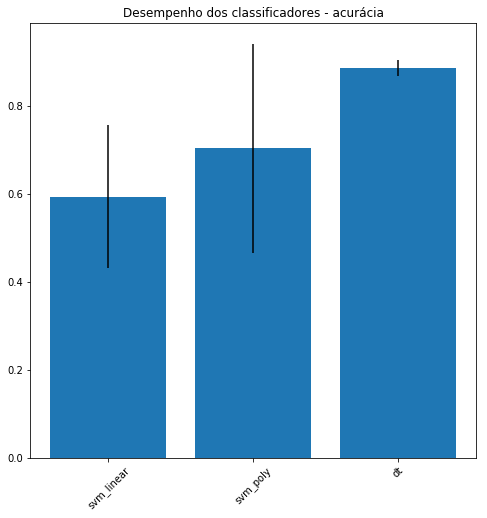

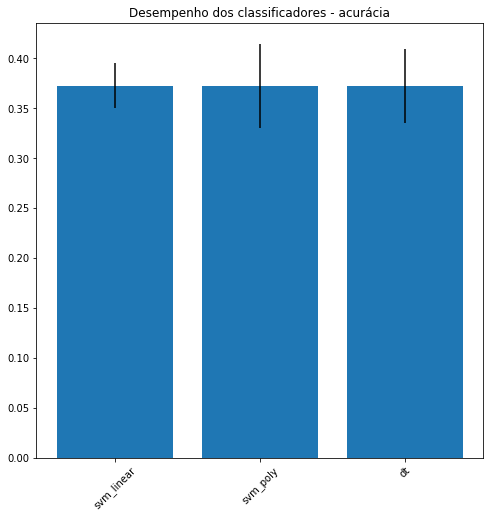

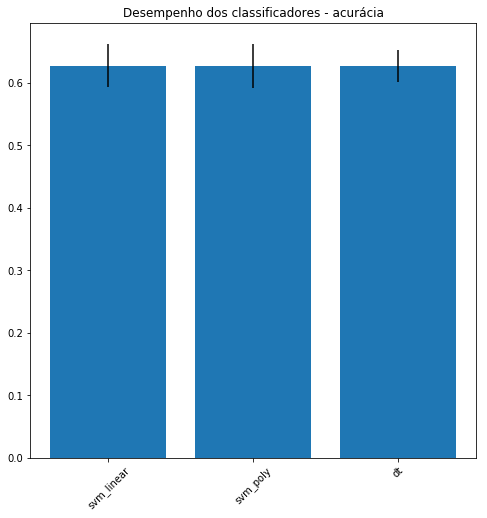

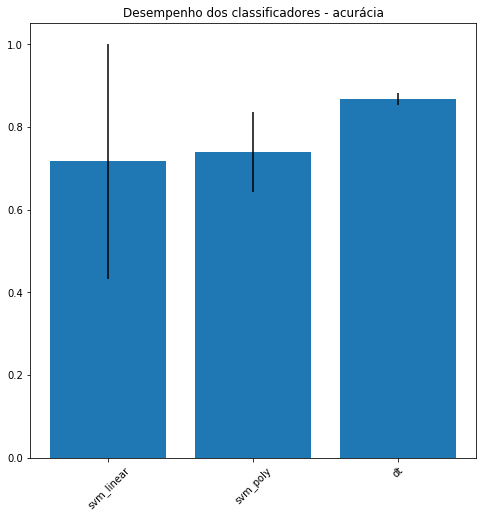

In [8]:
#Classificação no conjunto - Probabilidade igual
clf = classificacao(breast_cancer,[0,1,2], 3, weights={'M':0.5, 'B':0.5})

#Classificação no conjunto - Probabilidade desbalanceada
clf = classificacao(breast_cancer,[0,1,2], 3, weights={'M':1.0, 'B':0.0})

#Classificação no conjunto - Probabilidade desbalanceada
clf = classificacao(breast_cancer,[0,1,2], 3, weights={'M':0.0, 'B':1.0})

#Classificação no conjunto - Probabilidade balanceada
clf = classificacao(breast_cancer,[0,1,2], 3, weights=probs)

EXPLICAR QUE O DESBALANCEAMENTO PREJUFICA A ACURACIA. QUANDO DEIXAMOS 50% PARA CADA UM OBTEMOS O RESULTADO MAIS SATISFATORIO

FALAR SOBRE A CONVERSAO DE ATRIBUTOS
1 - ATRIBUTO AREA TERA 3 VALORES (NECESSARIO PARA FUTURAS ANALISES)
2 - CLASSE SERA BINARIA (IMPORTANTE PARA REDES NEURAIS COMO MLP)

In [9]:
#Vamos separar o atributo area em tres valores: pequeno, medio, largo.
min_area = breast_cancer['area'].min()
q1 = breast_cancer['area'].quantile(q=0.33)
q2 = breast_cancer['area'].quantile(q=0.66)
max_area = breast_cancer['area'].max()

#Separação dos atributos nos tres valores
breast_cancer['area'] = pd.cut(breast_cancer['area'],bins=[min_area,q1,q2,max_area],labels=['small','medium','large'])

#Mostrando dataset
breast_cancer.head()

,area,smoothness,texture,class
0,large,0.9053,0.006399,M
1,large,0.7339,0.005225,M
2,large,0.7869,0.006150,M
3,small,1.1560,0.009110,M
4,large,0.7813,0.011490,M


In [10]:
#Extração dos atributos
tmp_breast_cancer = breast_cancer.iloc[:,0:len(breast_cancer.columns)-1]

#Extração da classe
classes = breast_cancer['class'].unique()

#Geração das classes binarias
tmp_class = np.zeros([len(breast_cancer),len(classes)])

for i in range(len(classes)):
    for j in range(len(breast_cancer)):
        if(classes[i] == breast_cancer.iloc[j,3]):
            tmp_class[j,i] = 1
            
#Convertendo para um data frame
tmp_class = pd.DataFrame(tmp_class)

#Concatenando atributos
breast_cancer = pd.concat([tmp_breast_cancer,tmp_class],axis=1)

#Mudando o tipo
breast_cancer.iloc[:,3] = breast_cancer.iloc[:,3].astype(int)
breast_cancer.iloc[:,4] = breast_cancer.iloc[:,4].astype(int)

#Mostrando o dataset
breast_cancer.head()

,area,smoothness,texture,0,1
0,large,0.9053,0.006399,1,0
1,large,0.7339,0.005225,1,0
2,large,0.7869,0.006150,1,0
3,small,1.1560,0.009110,1,0
4,large,0.7813,0.011490,1,0


FALAR SOBRE A NORMALIZACAO. IMPORTANCIA: MUITOS ALGORITMOS DE AM PRECISAM QUE OS DADOS ESTEJAM EM INTERVALOS PEQUENO PARA QUE HAJA CONVERSAO

In [11]:
#Copiando dataset
tmp_cancer = breast_cancer.copy()

#Normalizando o atributo smoothness
tmp_cancer['smoothness'] = (breast_cancer['smoothness']-breast_cancer['smoothness'].min()) / (breast_cancer['smoothness'].max()-breast_cancer['smoothness'].min())

#Normalizando o atributo texture (z-score)
tmp_cancer['texture'] = (breast_cancer['texture']-breast_cancer['texture'].mean()) / breast_cancer['texture'].std()

#Mostrando os dados
tmp_cancer.head()

,area,smoothness,texture,0,1
0,large,0.120469,-0.213814,1,0
1,large,0.082589,-0.604819,1,0
2,large,0.094303,-0.296744,1,0
3,small,0.175875,0.689095,1,0
4,large,0.093065,1.481763,1,0


MOSTRAR QUE HOUVE NORMALIZACAO

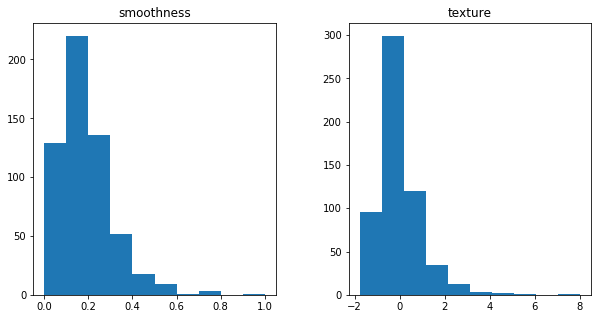

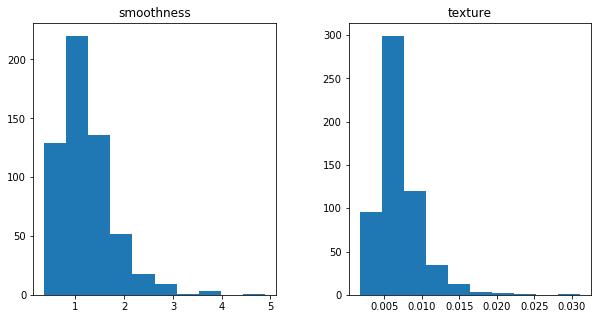

In [12]:
#Histograma dos atributos
tmp_cancer.iloc[:,1:3].hist(figsize=(10,5),grid=False)
breast_cancer.iloc[:,1:3].hist(figsize=(10,5),grid=False)
plt.show()

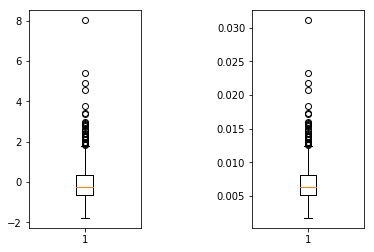

In [13]:
#Boxplot dos atributos
plt.subplot(121)
plt.boxplot(tmp_cancer['texture'])
plt.subplots_adjust(wspace=1)
plt.subplot(122)
plt.boxplot(breast_cancer['texture'])
plt.show()

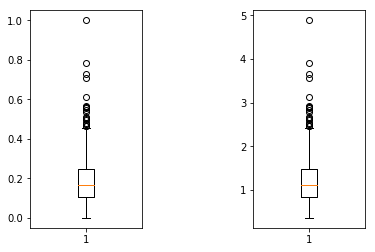

In [14]:
plt.subplot(121)
plt.boxplot(tmp_cancer['smoothness'])
plt.subplots_adjust(wspace=1)
plt.subplot(122)
plt.boxplot(breast_cancer['smoothness'])
plt.show()